In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange

import torch
from torch import nn

source = "../source"
sys.path.append(source)


from data import seq_data
from preprocessing import OneHot
from compilation import Compiler, ScalarTracker, ActivationTracker
from data_analysis.automata import to_automaton_history, reduce_automaton
from visualization.animation import SliderAnimation
from visualization.activations import ActivationsAnimation
from visualization.automata import AutomatonAnimation
from visualization.epochs import EpochAnimation

from model import Model
import publication

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [2]:
save = False

In [3]:
## Load settings
settings = "lazy"

(nonlinearity, gain, lr, P, L, n_epochs, max_seq_len) = (
    pd.read_csv("model settings/rnn.txt", sep=" ", header=0).loc[settings].to_numpy()
)
P, L, n_epochs, max_seq_len = int(P), int(L), int(n_epochs), int(max_seq_len)

In [4]:
## Generate data

# Define problem and data encoding
symbols = [0, 1]
encoding = OneHot(symbols)
problem = lambda seq: np.sum(seq) % 2  # XOR problem
# problem = lambda seq: (np.sum(seq) % 3) % 2

# Define sequence lengths for training and validation datasets
train_seq_lengths = list(range(1, max_seq_len + 1))
analysis_seq_lengths = [1, 2, 3, 4, 5, 6, 7, 8]
val_seq_length = 20
val_datapoints = 50

# Generate datasets
training_datasets = [
    seq_data(device, problem, encoding, seq_len=length) for length in train_seq_lengths
]
validation_datasets = [
    seq_data(
        device, problem, encoding, n_datapoints=val_datapoints, seq_len=val_seq_length
    )
]
analysis_data = [
    seq_data(device, problem, encoding, seq_len=length)
    for length in analysis_seq_lengths
]
tracked_datasets = validation_datasets + analysis_data + training_datasets

In [5]:
## Instantiate model
model = Model(
    encoding=encoding,
    input_size=2,
    output_size=2,
    hidden_dim=P,
    n_layers=L,
    device=device,
    nonlinearity=nonlinearity,
    gain=gain,
)

In [6]:
## Setup compiler
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, amsgrad=True)
compiler = Compiler(model, criterion, optimizer)
initial_hidden = model.init_hidden(batch_size=1)[-1]
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model,
        lambda inputs: model(inputs)[1][-1],
        analysis_data,
        initial=lambda: initial_hidden,
    ),
    "output": ActivationTracker(model, lambda inputs: model(inputs)[0], analysis_data),
}

In [7]:
## Training run
compiler.training_run(
    training_datasets,
    n_epochs=n_epochs,
    batch_size=128,
)

Training: 100%|██████████| 1000/1000 [03:11<00:00,  5.22steps/s, train_loss=0.00013, val_loss=0.22368]


In [128]:
## Visualize automaton dynamics

# Filter and process data for visualization
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "(Dataset < 10) "
data_hid = data_hid.query(query).copy()
data_output = data_output.query(query).copy()

epochs = list(set(data_hid.index.get_level_values("Epoch")))
epochs.sort()

std = float(np.linalg.norm(data_hid.std()))
n_points = len(data_hid.query("Epoch == 0"))

automaton_history = to_automaton_history(
    data_hid, data_output, merge_distance=0.5 * std
)
loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
n_states = np.array([len(automaton.states) for automaton in automaton_history])

# Create animation
publication.set_color_mixed()
animation = SliderAnimation(
    {
        "Hidden representations": ActivationsAnimation(
            data_hid, transform="PCA", colors=[5] * n_points
        ),
        "Output": ActivationsAnimation(
            data_output,
            transform="none",
            fixed_points=encoding.encoding,
            colors=[6] * n_points,
        ),
        "Automaton": AutomatonAnimation(automaton_history, reduce_automata=False),
        "Loss": EpochAnimation(
            graphs={
                "Training loss": train_loss,
                "Validation loss": val_loss,
            },
            unitless_graphs={
                "Number of states": n_states,
            },
            y_bounds=(0, 1),
        ),
    },
    parameters=epochs,
    parameter_name="Epoch",
    fig_size=4,
)

# Optionally export the animation
if save:
    animation.to_gif(f"plots/automaton_dynamics_{settings}")

Computing automata:  12%|█▏        | 119/1000 [00:05<00:38, 22.99it/s]


KeyboardInterrupt: 

In [167]:
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "(Dataset < 10) "
data_hid = data_hid.query(query).copy()
data_output = data_output.query(query).copy()

data_hid.query("Epoch == 0 | Epoch == 1")

0         1         2         3         4   \
Epoch Dataset Input                                                        
0      0      1        -0.899096  0.990158  0.837268 -0.210923 -0.361373   
              0        -0.875647  0.982221  0.839193 -0.088289 -0.257697   
       1      01       -0.723850  0.052784 -0.863060 -0.595247 -0.840518   
              10       -0.467407 -0.058592 -0.843697 -0.523113 -0.870489   
              00       -0.666821 -0.240069 -0.861399 -0.508078 -0.803394   
...                          ...       ...       ...       ...       ...   
1      7      00001110  0.378643  0.268413  0.074266 -0.115478  0.779917   
              00011001  0.035635  0.315558 -0.171018 -0.099645  0.638850   
              01001011  0.257456  0.549159 -0.143584 -0.235583  0.550207   
              11000110  0.433069  0.343081  0.170882 -0.318644  0.726976   
      -1      initial   1.000000  1.000000  1.000000  1.000000  1.000000   

                              5         6         7         8         9   ...  \
Epoch Dataset Input                                                       ...   
0      0      1        -0.488014  0.259043 -0.594441 -0.944799  0.695316  ...   
              0        -0.091591  0.085959 -0.511080 -0.944076  0.740237  ...   
       1      01        0.756733  0.470790  0.053921  0.862712  0.636645  ...   
              10        0.876278  0.436384 -0.078280  0.922285  0.729384  ...   
              00        0.891693  0.320473  0.172545  0.864413  0.688627  ...   
...                          ...       ...       ...       ...       ...  ...   
1      7      00001110  0.547515  0.314049 -0.652626  0.077234 -0.069053  ...   
              00011001 -0.233472  0.119398 -0.634305 -0.240279 -0.110457  ...   
              01001011 -0.174855  0.399585 -0.714498 -0.023392 -0.110104  ...   
              11000110  0.536438  0.413312 -0.441915  0.328251 -0.289434  ...   
      -1      initial   1.000000  1.000000  1.000000  1.000000  1.000000  ...   

                              90        91        92        93        94  \
Epoch Dataset Input                                                        
0      0      1        -0.932781 -0.035338  0.426887  0.968259  0.916462   
              0        -0.870872 -0.329815  0.366679  0.934299  0.870294   
       1      01        0.173264  0.430102  0.272827 -0.033207 -0.262848   
              10        0.567859  0.114068  0.225057 -0.121797 -0.586946   
              00        0.475946  0.151577  0.205447 -0.384792 -0.463175   
...                          ...       ...       ...       ...       ...   
1      7      00001110  0.025396 -0.068162  0.244552 -0.384316 -0.019306   
              00011001 -0.622370 -0.022213  0.302421 -0.061558  0.367097   
              01001011 -0.416127  0.101656  0.477526  0.386210  0.294571   
              11000110  0.125551 -0.399920  0.080217 -0.533952  0.078916   
      -1      initial   1.000000  1.000000  1.000000  1.000000  1.000000   

                              95        96        97        98        99  
Epoch Dataset Input                                                       
0      0      1        -0.734970  0.347530 -0.982417  0.746388  0.393956  
              0        -0.647294  0.439409 -0.978239  0.667891  0.360214  
       1      01        0.013019 -0.187058  0.077868  0.207330  0.472140  
              10        0.263875  0.220243  0.180172 -0.109009  0.298545  
              00        0.179866 -0.080247  0.183586  0.052506  0.441005  
...                          ...       ...       ...       ...       ...  
1      7      00001110  0.631269  0.838087  0.435045 -0.314367 -0.259494  
              00011001  0.532216  0.374940  0.144493 -0.481604 -0.128414  
              01001011  0.606327  0.798185  0.106129 -0.399826 -0.376418  
              11000110  0.417212  0.784239  0.596690 -0.634733 -0.187536  
      -1      initial   1.000000  1.000000  1.000000  1.000000  1.000000  

[1022 rows x 100 colum

In [168]:
for epoch, hidden_states_current in data_hid.groupby("Epoch"):
    print(hidden_states_current)

                              0         1         2         3         4   \
Epoch Dataset Input                                                        
0      0      1        -0.899096  0.990158  0.837268 -0.210923 -0.361373   
              0        -0.875647  0.982221  0.839193 -0.088289 -0.257697   
       1      01       -0.723850  0.052784 -0.863060 -0.595247 -0.840518   
              10       -0.467407 -0.058592 -0.843697 -0.523113 -0.870489   
              00       -0.666821 -0.240069 -0.861399 -0.508078 -0.803394   
...                          ...       ...       ...       ...       ...   
       7      00001110  0.223559  0.081356 -0.080348  0.042824  0.589217   
              00011001 -0.146316  0.051219 -0.298461  0.118163  0.363315   
              01001011  0.146399  0.303841 -0.240361 -0.073637  0.231152   
              11000110  0.241462  0.066354  0.097081 -0.189810  0.403815   
      -1      initial   1.000000  1.000000  1.000000  1.000000  1.000000   

           

In [166]:
for epoch, hidden_states_current in data_hid.groupby("Epoch"):
    print(hidden_states_current)

                             0         1         2         3         4   \
Dataset Input   Epoch                                                     
0       0       0     -0.898208  0.955248  0.922038 -0.610614  0.188959   
        1       0     -0.990008  0.996253  0.902962 -0.694642 -0.050582   
1       11      0     -0.362176  0.997951 -0.980929 -0.734591 -0.644934   
        10      0      0.666721  0.975301 -0.976083 -0.659347 -0.481315   
        01      0     -0.987098  0.811037 -0.925260 -0.525146 -0.632869   
...                         ...       ...       ...       ...       ...   
6       1110011 0      0.142877  0.999887 -0.674626 -0.070913  0.249826   
        1100011 0     -0.196321  0.995341 -0.910332 -0.048182  0.607493   
        1100010 0      0.755352  0.944633 -0.888556  0.098430  0.738340   
        0000100 0     -0.314929 -0.988224 -0.443610 -0.141705  0.272709   
        1110111 0     -0.316458  0.990907 -0.765964 -0.337742 -0.302520   

                        

In [193]:
data_hid = get_activations(datasets, lambda inputs: model(inputs)[1][-1], encoding)


data_hid_0 = data_hid.copy()
index = data_hid_0.index.to_frame()
index["Epoch"] = 0
index = index[["Epoch", "Dataset", "Input"]]
index

Epoch  Dataset    Input
Dataset Input                           
0       0            0        0        0
        1            0        0        1
1       11           0        1       11
        10           0        1       10
        01           0        1       01
...                ...      ...      ...
6       1110011      0        6  1110011
        1100011      0        6  1100011
        1100010      0        6  1100010
        0000100      0        6  0000100
        1110111      0        6  1110111

[254 rows x 3 columns]

In [196]:
from activations import get_activations


datasets = training_datasets
model
encoding

data_hid = get_activations(datasets, lambda inputs: model(inputs)[1][-1], encoding)
data_output = get_activations(datasets, lambda inputs: model(inputs)[0], encoding)
std = float(np.linalg.norm(data_hid.std()))

## Add epoch index
data_hid_0 = data_hid.copy()
index = data_hid_0.index.to_frame()
index["Epoch"] = 0
index = index[["Epoch", "Dataset", "Input"]]
data_hid_0.index = pd.MultiIndex.from_frame(index)

data_hid_1 = data_hid.copy()
index = data_hid_1.index.to_frame()
index["Epoch"] = 1
index = index[["Epoch", "Dataset", "Input"]]
data_hid_1.index = pd.MultiIndex.from_frame(index)

data_hid = pd.concat([data_hid_0, data_hid_1])

data_output_0 = data_hid.copy()
index = data_output_0.index.to_frame()
index["Epoch"] = 0
index = index[["Epoch", "Dataset", "Input"]]
data_output_0.index = pd.MultiIndex.from_frame(index)

data_output_1 = data_hid.copy()
index = data_output_1.index.to_frame()
index["Epoch"] = 1
index = index[["Epoch", "Dataset", "Input"]]
data_output_1.index = pd.MultiIndex.from_frame(index)

data_output = pd.concat([data_output_0, data_output_1])


automaton = to_automaton_history(
    data_hid,
    data_output,
    merge_distance=0.5 * std,
)

Computing automata: 100%|██████████| 2/2 [00:00<00:00, 12.99it/s]


In [203]:
data_output

0         1         2         3         4   \
Epoch Dataset Input                                                       
0     0       0       -0.898208  0.955248  0.922038 -0.610614  0.188959   
              1       -0.990008  0.996253  0.902962 -0.694642 -0.050582   
      1       11      -0.362176  0.997951 -0.980929 -0.734591 -0.644934   
              10       0.666721  0.975301 -0.976083 -0.659347 -0.481315   
              01      -0.987098  0.811037 -0.925260 -0.525146 -0.632869   
...                         ...       ...       ...       ...       ...   
1     6       1110011  0.142877  0.999887 -0.674626 -0.070913  0.249826   
              1100011 -0.196321  0.995341 -0.910332 -0.048182  0.607493   
              1100010  0.755352  0.944633 -0.888556  0.098430  0.738340   
              0000100 -0.314929 -0.988224 -0.443610 -0.141705  0.272709   
              1110111 -0.316458  0.990907 -0.765964 -0.337742 -0.302520   

                             5         6         7         8         9   ...  \
Epoch Dataset Input                                                      ...   
0     0       0        0.706862  0.002916  0.263259 -0.967493  0.933597  ...   
              1        0.028082  0.413275 -0.014630 -0.955898  0.932431  ...   
      1       11       0.451203  0.343843 -0.623615  0.956103  0.575451  ...   
              10       0.871433 -0.078035 -0.419151  0.940567  0.581443  ...   
              01      -0.005072  0.027658  0.317570  0.919206 -0.204044  ...   
...                         ...       ...       ...       ...       ...  ...   
1     6       1110011 -0.008927  0.829312 -0.707662 -0.263545  0.679043  ...   
              1100011  0.308176  0.703313 -0.606437  0.001132  0.670236  ...   
              1100010  0.824696  0.411311 -0.396112 -0.153139  0.675167  ...   
              0000100  0.944874  0.058648 -0.469782 -0.547400 -0.784467  ...   
              1110111  0.724810  0.648701 -0.898110 -0.231498  0.469939  ...   

                             90        91        92        93        94  \
Epoch Dataset Input                                                       
0     0       0       -0.995443 -0.999979 -0.775292  0.987752  0.225610   
              1       -0.998948 -0.998892 -0.714697  0.997872  0.851968   
      1       11       0.978237  0.151856  0.330589  0.024404  0.430959   
              10       0.994944 -0.950360  0.203854 -0.692772 -0.517307   
              01       0.980978  0.994857  0.092228 -0.866742  0.648064   
...                         ...       ...       ...       ...       ...   
1     6       1110011 -0.976244 -0.928029  0.100897  0.992867  0.790747   
              1100011 -0.579752  0.751225  0.368180  0.854547  0.673430   
              1100010  0.071831 -0.766903  0.244521  0.375747 -0.213405   
              0000100  0.797437 -0.449699 -0.198379 -0.930469 -0.482026   
              1110111  0.280602 -0.056816  0.163457  0.451893  0.399985   

                             95        96        97        98        99  
Epoch Dataset Input                                                      
0     0       0       -0.747111  0.840005 -0.898145 -0.494298 -0.258147  
              1       -0.842944  0.759625 -0.929370 -0.502235 -0.274540  
      1       11       0.574377  0.870019  0.595490 -0.446255  0.054765  
              10       0.725380  0.915262  0.705082 -0.437761  0.072339  
              01       0.194229  0.826761  0.074249  0.354748  0.270863  
...                         ...       ...       ...       ...       ...  
1     6       1110011 -0.132010  0.607467 -0.346667 -0.806165 -0.789361  
              1100011 -0.040270  0.665294  0.528670 -0.727126 -0.422160  
              1100010  0.220882  0.773151  0.652421 -0.722113 -0.407552  
              0000100 -0.362975 -0.403874 -0.873108 -0.242874  0.564514  
              1110111 -0.215084  0.438383  0.217942 -0.645810 -0.168199  

[1016 rows x 100 columns]

100%|██████████| 100/100 [00:00<00:00, 180.44it/s]


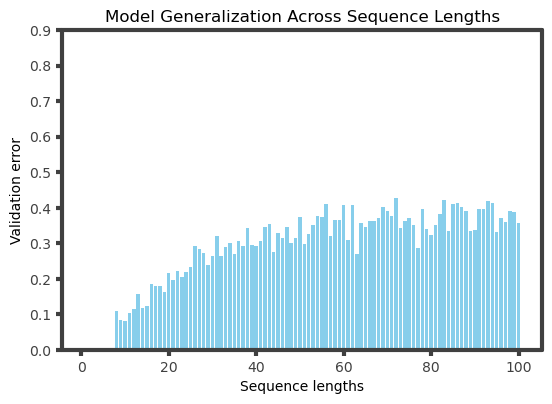

In [9]:
## Check for large sequence length generalization

# Evaluate model generalization for sequences of varying lengths
N = 100
val_data = []
for n in trange(1, N + 1):
    val_data.append(seq_data(device, problem, encoding, n_datapoints=100, seq_len=n))
val_err = compiler.validation(val_data).to_numpy()[:, 0]

# Visualize validation error for varying sequence lengths
publication.set_color_mixed()
fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(np.arange(1, N + 1), val_err, color="skyblue")
ax.set_xlabel("Sequence lengths")
ax.set_ylabel("Validation error")
ax.set_title("Model Generalization Across Sequence Lengths")
ax.set_yticks(np.arange(0, 1, 0.1))
if save:
    publication.pub_show(save_path=f"plots/validation_error_{settings}")
else:
    publication.pub_show()